# PTN Template
This notebook serves as a template for single dataset PTN experiments  
It can be run on its own by setting STANDALONE to True (do a find for "STANDALONE" to see where)  
But it is intended to be executed as part of a *papermill.py script. See any of the   
experimentes with a papermill script to get started with that workflow.  

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Required Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "labels_source",
    "labels_target",
    "domains_source",
    "domains_target",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "n_shot",
    "n_way",
    "n_query",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_transforms_source",
    "x_transforms_target",
    "episode_transforms_source",
    "episode_transforms_target",
    "pickle_name",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "torch_default_dtype"
}

In [3]:


standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337


standalone_parameters["num_examples_per_domain_per_label_source"]=100
standalone_parameters["num_examples_per_domain_per_label_target"]=100

standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 100

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "target_accuracy"

standalone_parameters["x_transforms_source"] = ["unit_power"]
standalone_parameters["x_transforms_target"] = ["unit_power"]
standalone_parameters["episode_transforms_source"] = []
standalone_parameters["episode_transforms_target"] = []

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

# uncomment for CORES dataset
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)


standalone_parameters["labels_source"] = ALL_NODES
standalone_parameters["labels_target"] = ALL_NODES

standalone_parameters["domains_source"] = [1]
standalone_parameters["domains_target"] = [2,3,4,5]

standalone_parameters["pickle_name"] = "cores.stratified_ds.2022A.pkl"


# Uncomment these for ORACLE dataset
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )
# standalone_parameters["labels_source"] = ALL_SERIAL_NUMBERS
# standalone_parameters["labels_target"] = ALL_SERIAL_NUMBERS
# standalone_parameters["domains_source"] = [8,20, 38,50]
# standalone_parameters["domains_target"] = [14, 26, 32, 44, 56]
# standalone_parameters["pickle_name"] = "oracle.frame_indexed.stratified_ds.2022A.pkl"
# standalone_parameters["num_examples_per_domain_per_label_source"]=1000
# standalone_parameters["num_examples_per_domain_per_label_target"]=1000

# Uncomment these for Metahan dataset
# standalone_parameters["labels_source"] = list(range(19))
# standalone_parameters["labels_target"] = list(range(19))
# standalone_parameters["domains_source"] = [0]
# standalone_parameters["domains_target"] = [1]
# standalone_parameters["pickle_name"] = "metehan.stratified_ds.2022A.pkl"
# standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])
# standalone_parameters["num_examples_per_domain_per_label_source"]=200
# standalone_parameters["num_examples_per_domain_per_label_target"]=100


standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])

In [4]:
# Parameters
parameters = {
    "experiment_name": "tuned_1v2:oracle.run1.framed",
    "device": "cuda",
    "lr": 0.0001,
    "labels_source": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "labels_target": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "episode_transforms_source": [],
    "episode_transforms_target": [],
    "domains_source": [8, 32, 50],
    "domains_target": [14, 20, 26, 38, 44],
    "num_examples_per_domain_per_label_source": -1,
    "num_examples_per_domain_per_label_target": -1,
    "n_shot": 3,
    "n_way": 16,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "pickle_name": "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl",
    "x_transforms_source": ["unit_power"],
    "x_transforms_target": ["unit_power"],
    "dataset_seed": 500,
    "seed": 500,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
# (This is due to the randomized initial weights)
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
###################################
# Build the dataset
###################################

if p.x_transforms_source == []: x_transform_source = None
else: x_transform_source = get_chained_transform(p.x_transforms_source) 

if p.x_transforms_target == []: x_transform_target = None
else: x_transform_target = get_chained_transform(p.x_transforms_target)

if p.episode_transforms_source == []: episode_transform_source = None
else: raise Exception("episode_transform_source not implemented")

if p.episode_transforms_target == []: episode_transform_target = None
else: raise Exception("episode_transform_target not implemented")


eaf_source = Episodic_Accessor_Factory(
    labels=p.labels_source,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_source,
    example_transform_func=episode_transform_source,
    
)
train_original_source, val_original_source, test_original_source = eaf_source.get_train(), eaf_source.get_val(), eaf_source.get_test()


eaf_target = Episodic_Accessor_Factory(
    labels=p.labels_target,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_target,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_target,
    example_transform_func=episode_transform_target,
)
train_original_target, val_original_target, test_original_target = eaf_target.get_train(), eaf_target.get_val(), eaf_target.get_test()


transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
# Some quick unit tests on the data
from steves_utils.transforms import get_average_power, get_average_magnitude

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_source))

assert q_x.dtype == eval(p.torch_default_dtype)
assert s_x.dtype == eval(p.torch_default_dtype)

print("Visually inspect these to see if they line up with expected values given the transforms")
print('x_transforms_source', p.x_transforms_source)
print('x_transforms_target', p.x_transforms_target)
print("Average magnitude, source:", get_average_magnitude(q_x[0].numpy()))
print("Average power, source:", get_average_power(q_x[0].numpy()))

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_target))
print("Average magnitude, target:", get_average_magnitude(q_x[0].numpy()))
print("Average power, target:", get_average_power(q_x[0].numpy()))


Visually inspect these to see if they line up with expected values given the transforms
x_transforms_source ['unit_power']
x_transforms_target ['unit_power']
Average magnitude, source: 0.9579502
Average power, source: 1.0


Average magnitude, target: 0.9591304
Average power, target: 1.0


In [12]:
###################################
# Build the model
###################################
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=(2,256))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [13]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 2520], examples_per_second: 84.5299, train_label_loss: 3.0021, 


epoch: 1, [batch: 252 / 2520], examples_per_second: 2472.7495, train_label_loss: 1.8027, 


epoch: 1, [batch: 504 / 2520], examples_per_second: 1904.4064, train_label_loss: 1.2940, 


epoch: 1, [batch: 756 / 2520], examples_per_second: 1841.2947, train_label_loss: 1.4204, 


epoch: 1, [batch: 1008 / 2520], examples_per_second: 2107.2602, train_label_loss: 0.9369, 


epoch: 1, [batch: 1260 / 2520], examples_per_second: 2068.3491, train_label_loss: 0.7537, 


epoch: 1, [batch: 1512 / 2520], examples_per_second: 1860.3792, train_label_loss: 0.6832, 


epoch: 1, [batch: 1764 / 2520], examples_per_second: 1863.4102, train_label_loss: 0.6602, 


epoch: 1, [batch: 2016 / 2520], examples_per_second: 2328.0766, train_label_loss: 0.7779, 


epoch: 1, [batch: 2268 / 2520], examples_per_second: 1849.0519, train_label_loss: 0.5896, 


epoch: 1, source_val_acc_label: 0.7269, target_val_acc_label: 0.6595, source_val_label_loss: 0.8305, target_val_label_loss: 2.2280, 


New best


epoch: 2, [batch: 1 / 2520], examples_per_second: 3.5295, train_label_loss: 0.9417, 


epoch: 2, [batch: 252 / 2520], examples_per_second: 2300.3099, train_label_loss: 0.8625, 


epoch: 2, [batch: 504 / 2520], examples_per_second: 1817.4352, train_label_loss: 0.6188, 


epoch: 2, [batch: 756 / 2520], examples_per_second: 1814.6001, train_label_loss: 0.5793, 


epoch: 2, [batch: 1008 / 2520], examples_per_second: 2253.4122, train_label_loss: 0.3772, 


epoch: 2, [batch: 1260 / 2520], examples_per_second: 2202.7574, train_label_loss: 0.5179, 


epoch: 2, [batch: 1512 / 2520], examples_per_second: 2193.4988, train_label_loss: 0.7897, 


epoch: 2, [batch: 1764 / 2520], examples_per_second: 2218.6286, train_label_loss: 0.8335, 


epoch: 2, [batch: 2016 / 2520], examples_per_second: 3059.6319, train_label_loss: 0.8601, 


epoch: 2, [batch: 2268 / 2520], examples_per_second: 2235.3833, train_label_loss: 0.6573, 


epoch: 2, source_val_acc_label: 0.8039, target_val_acc_label: 0.7376, source_val_label_loss: 0.5557, target_val_label_loss: 1.9654, 


New best


epoch: 3, [batch: 1 / 2520], examples_per_second: 4.3864, train_label_loss: 0.5126, 


epoch: 3, [batch: 252 / 2520], examples_per_second: 2034.2193, train_label_loss: 0.5715, 


epoch: 3, [batch: 504 / 2520], examples_per_second: 2553.0199, train_label_loss: 0.5297, 


epoch: 3, [batch: 756 / 2520], examples_per_second: 2414.6532, train_label_loss: 0.6046, 


epoch: 3, [batch: 1008 / 2520], examples_per_second: 2760.7102, train_label_loss: 0.6915, 


epoch: 3, [batch: 1260 / 2520], examples_per_second: 3062.7898, train_label_loss: 0.5619, 


epoch: 3, [batch: 1512 / 2520], examples_per_second: 3708.7266, train_label_loss: 0.5575, 


epoch: 3, [batch: 1764 / 2520], examples_per_second: 3792.3309, train_label_loss: 0.4744, 


epoch: 3, [batch: 2016 / 2520], examples_per_second: 3854.5850, train_label_loss: 0.2831, 


epoch: 3, [batch: 2268 / 2520], examples_per_second: 4021.8776, train_label_loss: 0.5553, 


epoch: 3, source_val_acc_label: 0.8226, target_val_acc_label: 0.7382, source_val_label_loss: 0.4873, target_val_label_loss: 2.4195, 


New best


epoch: 4, [batch: 1 / 2520], examples_per_second: 9.2321, train_label_loss: 0.3438, 


epoch: 4, [batch: 252 / 2520], examples_per_second: 4669.8519, train_label_loss: 0.7995, 


epoch: 4, [batch: 504 / 2520], examples_per_second: 4048.0753, train_label_loss: 0.3576, 


epoch: 4, [batch: 756 / 2520], examples_per_second: 3814.3086, train_label_loss: 0.2766, 


epoch: 4, [batch: 1008 / 2520], examples_per_second: 2788.3807, train_label_loss: 0.3882, 


epoch: 4, [batch: 1260 / 2520], examples_per_second: 1935.9581, train_label_loss: 0.3856, 


epoch: 4, [batch: 1512 / 2520], examples_per_second: 1913.1387, train_label_loss: 0.3066, 


epoch: 4, [batch: 1764 / 2520], examples_per_second: 1801.5294, train_label_loss: 0.5103, 


epoch: 4, [batch: 2016 / 2520], examples_per_second: 2450.7103, train_label_loss: 0.4138, 


epoch: 4, [batch: 2268 / 2520], examples_per_second: 3731.8298, train_label_loss: 0.3138, 


epoch: 4, source_val_acc_label: 0.8504, target_val_acc_label: 0.7689, source_val_label_loss: 0.4166, target_val_label_loss: 2.5191, 


New best


epoch: 5, [batch: 1 / 2520], examples_per_second: 8.8867, train_label_loss: 0.3789, 


epoch: 5, [batch: 252 / 2520], examples_per_second: 4454.8247, train_label_loss: 0.3882, 


epoch: 5, [batch: 504 / 2520], examples_per_second: 2164.4947, train_label_loss: 0.4037, 


epoch: 5, [batch: 756 / 2520], examples_per_second: 1793.9482, train_label_loss: 0.4073, 


epoch: 5, [batch: 1008 / 2520], examples_per_second: 1840.4139, train_label_loss: 0.4299, 


epoch: 5, [batch: 1260 / 2520], examples_per_second: 2050.8699, train_label_loss: 0.3177, 


epoch: 5, [batch: 1512 / 2520], examples_per_second: 3174.3665, train_label_loss: 0.3699, 


epoch: 5, [batch: 1764 / 2520], examples_per_second: 3916.9496, train_label_loss: 0.5361, 


epoch: 5, [batch: 2016 / 2520], examples_per_second: 3944.8130, train_label_loss: 0.1283, 


epoch: 5, [batch: 2268 / 2520], examples_per_second: 3868.9559, train_label_loss: 0.3235, 


epoch: 5, source_val_acc_label: 0.8758, target_val_acc_label: 0.7887, source_val_label_loss: 0.3588, target_val_label_loss: 2.7953, 


New best


epoch: 6, [batch: 1 / 2520], examples_per_second: 5.2808, train_label_loss: 0.2453, 


epoch: 6, [batch: 252 / 2520], examples_per_second: 2016.9126, train_label_loss: 0.3019, 


epoch: 6, [batch: 504 / 2520], examples_per_second: 2599.0777, train_label_loss: 0.3174, 


epoch: 6, [batch: 756 / 2520], examples_per_second: 3873.5234, train_label_loss: 0.0707, 


epoch: 6, [batch: 1008 / 2520], examples_per_second: 3820.7936, train_label_loss: 0.2343, 


epoch: 6, [batch: 1260 / 2520], examples_per_second: 4025.1066, train_label_loss: 0.2570, 


epoch: 6, [batch: 1512 / 2520], examples_per_second: 3921.3229, train_label_loss: 0.3687, 


epoch: 6, [batch: 1764 / 2520], examples_per_second: 3782.1693, train_label_loss: 0.1919, 


epoch: 6, [batch: 2016 / 2520], examples_per_second: 2325.9935, train_label_loss: 0.1086, 


epoch: 6, [batch: 2268 / 2520], examples_per_second: 2095.3666, train_label_loss: 0.1945, 


epoch: 6, source_val_acc_label: 0.8781, target_val_acc_label: 0.7810, source_val_label_loss: 0.3492, target_val_label_loss: 3.0462, 


epoch: 7, [batch: 1 / 2520], examples_per_second: 3.9167, train_label_loss: 0.1988, 


epoch: 7, [batch: 252 / 2520], examples_per_second: 4442.1815, train_label_loss: 0.1043, 


epoch: 7, [batch: 504 / 2520], examples_per_second: 3685.0979, train_label_loss: 0.1732, 


epoch: 7, [batch: 756 / 2520], examples_per_second: 3952.8614, train_label_loss: 0.2495, 


epoch: 7, [batch: 1008 / 2520], examples_per_second: 3914.3325, train_label_loss: 0.3135, 


epoch: 7, [batch: 1260 / 2520], examples_per_second: 3902.7581, train_label_loss: 0.0560, 


epoch: 7, [batch: 1512 / 2520], examples_per_second: 2045.7949, train_label_loss: 0.2571, 


epoch: 7, [batch: 1764 / 2520], examples_per_second: 1788.3920, train_label_loss: 0.2745, 


epoch: 7, [batch: 2016 / 2520], examples_per_second: 1890.0615, train_label_loss: 0.3051, 


epoch: 7, [batch: 2268 / 2520], examples_per_second: 1795.3531, train_label_loss: 0.2382, 


epoch: 7, source_val_acc_label: 0.8927, target_val_acc_label: 0.7971, source_val_label_loss: 0.3049, target_val_label_loss: 3.1439, 


New best


epoch: 8, [batch: 1 / 2520], examples_per_second: 6.2292, train_label_loss: 0.2495, 


epoch: 8, [batch: 252 / 2520], examples_per_second: 3941.6595, train_label_loss: 0.1472, 


epoch: 8, [batch: 504 / 2520], examples_per_second: 3951.0054, train_label_loss: 0.0528, 


epoch: 8, [batch: 756 / 2520], examples_per_second: 3745.7106, train_label_loss: 0.2291, 


epoch: 8, [batch: 1008 / 2520], examples_per_second: 3261.9640, train_label_loss: 0.1540, 


epoch: 8, [batch: 1260 / 2520], examples_per_second: 1926.3277, train_label_loss: 0.2813, 


epoch: 8, [batch: 1512 / 2520], examples_per_second: 1860.3010, train_label_loss: 0.3456, 


epoch: 8, [batch: 1764 / 2520], examples_per_second: 1821.3032, train_label_loss: 0.3135, 


epoch: 8, [batch: 2016 / 2520], examples_per_second: 2277.0054, train_label_loss: 0.3563, 


epoch: 8, [batch: 2268 / 2520], examples_per_second: 3708.2756, train_label_loss: 0.2014, 


epoch: 8, source_val_acc_label: 0.8977, target_val_acc_label: 0.7971, source_val_label_loss: 0.3001, target_val_label_loss: 3.0813, 


New best


epoch: 9, [batch: 1 / 2520], examples_per_second: 9.3854, train_label_loss: 0.3894, 


epoch: 9, [batch: 252 / 2520], examples_per_second: 3903.4092, train_label_loss: 0.0296, 


epoch: 9, [batch: 504 / 2520], examples_per_second: 2310.2788, train_label_loss: 0.1652, 


epoch: 9, [batch: 756 / 2520], examples_per_second: 1961.3590, train_label_loss: 0.2919, 


epoch: 9, [batch: 1008 / 2520], examples_per_second: 1822.0977, train_label_loss: 0.1826, 


epoch: 9, [batch: 1260 / 2520], examples_per_second: 1865.2254, train_label_loss: 0.2913, 


epoch: 9, [batch: 1512 / 2520], examples_per_second: 1814.5963, train_label_loss: 0.2101, 


epoch: 9, [batch: 1764 / 2520], examples_per_second: 2312.3288, train_label_loss: 0.2172, 


epoch: 9, [batch: 2016 / 2520], examples_per_second: 3574.3408, train_label_loss: 0.0348, 


epoch: 9, [batch: 2268 / 2520], examples_per_second: 3736.9193, train_label_loss: 0.1985, 


epoch: 9, source_val_acc_label: 0.9025, target_val_acc_label: 0.7992, source_val_label_loss: 0.2916, target_val_label_loss: 3.3001, 


New best


epoch: 10, [batch: 1 / 2520], examples_per_second: 9.2595, train_label_loss: 0.2670, 


epoch: 10, [batch: 252 / 2520], examples_per_second: 2122.4135, train_label_loss: 0.1548, 


epoch: 10, [batch: 504 / 2520], examples_per_second: 1796.6429, train_label_loss: 0.1396, 


epoch: 10, [batch: 756 / 2520], examples_per_second: 1896.1313, train_label_loss: 0.2749, 


epoch: 10, [batch: 1008 / 2520], examples_per_second: 1799.0989, train_label_loss: 0.1404, 


epoch: 10, [batch: 1260 / 2520], examples_per_second: 1803.8200, train_label_loss: 0.1132, 


epoch: 10, [batch: 1512 / 2520], examples_per_second: 2833.4615, train_label_loss: 0.0693, 


epoch: 10, [batch: 1764 / 2520], examples_per_second: 3968.6171, train_label_loss: 0.1835, 


epoch: 10, [batch: 2016 / 2520], examples_per_second: 3889.7862, train_label_loss: 0.1063, 


epoch: 10, [batch: 2268 / 2520], examples_per_second: 3898.2848, train_label_loss: 0.2268, 


epoch: 10, source_val_acc_label: 0.9122, target_val_acc_label: 0.8085, source_val_label_loss: 0.2676, target_val_label_loss: 3.4767, 


New best


epoch: 11, [batch: 1 / 2520], examples_per_second: 6.6424, train_label_loss: 0.1208, 


epoch: 11, [batch: 252 / 2520], examples_per_second: 1919.5848, train_label_loss: 0.3622, 


epoch: 11, [batch: 504 / 2520], examples_per_second: 1790.9302, train_label_loss: 0.1844, 


epoch: 11, [batch: 756 / 2520], examples_per_second: 2802.3751, train_label_loss: 0.1568, 


epoch: 11, [batch: 1008 / 2520], examples_per_second: 3959.4833, train_label_loss: 0.3709, 


epoch: 11, [batch: 1260 / 2520], examples_per_second: 3769.1746, train_label_loss: 0.2586, 


epoch: 11, [batch: 1512 / 2520], examples_per_second: 3952.9937, train_label_loss: 0.0628, 


epoch: 11, [batch: 1764 / 2520], examples_per_second: 3964.7516, train_label_loss: 0.0619, 


epoch: 11, [batch: 2016 / 2520], examples_per_second: 3802.0634, train_label_loss: 0.1772, 


epoch: 11, [batch: 2268 / 2520], examples_per_second: 2259.1612, train_label_loss: 0.0640, 


epoch: 11, source_val_acc_label: 0.9107, target_val_acc_label: 0.8047, source_val_label_loss: 0.2751, target_val_label_loss: 3.9679, 


epoch: 12, [batch: 1 / 2520], examples_per_second: 3.6848, train_label_loss: 0.1412, 


epoch: 12, [batch: 252 / 2520], examples_per_second: 3901.8770, train_label_loss: 0.2601, 


epoch: 12, [batch: 504 / 2520], examples_per_second: 4047.7831, train_label_loss: 0.2031, 


epoch: 12, [batch: 756 / 2520], examples_per_second: 3933.3480, train_label_loss: 0.0923, 


epoch: 12, [batch: 1008 / 2520], examples_per_second: 3931.9488, train_label_loss: 0.0451, 


epoch: 12, [batch: 1260 / 2520], examples_per_second: 3836.6967, train_label_loss: 0.0900, 


epoch: 12, [batch: 1512 / 2520], examples_per_second: 3368.5507, train_label_loss: 0.1239, 


epoch: 12, [batch: 1764 / 2520], examples_per_second: 1909.7618, train_label_loss: 0.0149, 


epoch: 12, [batch: 2016 / 2520], examples_per_second: 1866.8067, train_label_loss: 0.1661, 


epoch: 12, [batch: 2268 / 2520], examples_per_second: 1830.3319, train_label_loss: 0.3128, 


epoch: 12, source_val_acc_label: 0.9156, target_val_acc_label: 0.8109, source_val_label_loss: 0.2680, target_val_label_loss: 4.4657, 


New best


epoch: 13, [batch: 1 / 2520], examples_per_second: 5.3364, train_label_loss: 0.0878, 


epoch: 13, [batch: 252 / 2520], examples_per_second: 3988.1379, train_label_loss: 0.0552, 


epoch: 13, [batch: 504 / 2520], examples_per_second: 3946.3772, train_label_loss: 0.0335, 


epoch: 13, [batch: 756 / 2520], examples_per_second: 4107.4025, train_label_loss: 0.0336, 


epoch: 13, [batch: 1008 / 2520], examples_per_second: 3680.3643, train_label_loss: 0.1255, 


epoch: 13, [batch: 1260 / 2520], examples_per_second: 2102.9019, train_label_loss: 0.1298, 


epoch: 13, [batch: 1512 / 2520], examples_per_second: 1796.5214, train_label_loss: 0.0157, 


epoch: 13, [batch: 1764 / 2520], examples_per_second: 1855.1662, train_label_loss: 0.4018, 


epoch: 13, [batch: 2016 / 2520], examples_per_second: 1847.4778, train_label_loss: 0.0055, 


epoch: 13, [batch: 2268 / 2520], examples_per_second: 1779.5041, train_label_loss: 0.0695, 


epoch: 13, source_val_acc_label: 0.9221, target_val_acc_label: 0.8129, source_val_label_loss: 0.2460, target_val_label_loss: 3.8695, 


New best


epoch: 14, [batch: 1 / 2520], examples_per_second: 8.4277, train_label_loss: 0.1360, 


epoch: 14, [batch: 252 / 2520], examples_per_second: 4373.7493, train_label_loss: 0.2300, 


epoch: 14, [batch: 504 / 2520], examples_per_second: 4423.0406, train_label_loss: 0.0513, 


epoch: 14, [batch: 756 / 2520], examples_per_second: 4446.3728, train_label_loss: 0.1359, 


epoch: 14, [batch: 1008 / 2520], examples_per_second: 2628.7414, train_label_loss: 0.0365, 


epoch: 14, [batch: 1260 / 2520], examples_per_second: 2221.3294, train_label_loss: 0.0234, 


epoch: 14, [batch: 1512 / 2520], examples_per_second: 2025.8405, train_label_loss: 0.0042, 


epoch: 14, [batch: 1764 / 2520], examples_per_second: 1962.9719, train_label_loss: 0.1888, 


epoch: 14, [batch: 2016 / 2520], examples_per_second: 2017.0274, train_label_loss: 0.1724, 


epoch: 14, [batch: 2268 / 2520], examples_per_second: 2485.1099, train_label_loss: 0.2530, 


epoch: 14, source_val_acc_label: 0.9181, target_val_acc_label: 0.8029, source_val_label_loss: 0.2564, target_val_label_loss: 4.4270, 


epoch: 15, [batch: 1 / 2520], examples_per_second: 10.4118, train_label_loss: 0.1988, 


epoch: 15, [batch: 252 / 2520], examples_per_second: 4779.8084, train_label_loss: 0.1104, 


epoch: 15, [batch: 504 / 2520], examples_per_second: 5003.2412, train_label_loss: 0.1113, 


epoch: 15, [batch: 756 / 2520], examples_per_second: 5057.7494, train_label_loss: 0.0858, 


epoch: 15, [batch: 1008 / 2520], examples_per_second: 2877.1363, train_label_loss: 0.1268, 


epoch: 15, [batch: 1260 / 2520], examples_per_second: 2579.5317, train_label_loss: 0.0670, 


epoch: 15, [batch: 1512 / 2520], examples_per_second: 2356.4498, train_label_loss: 0.0497, 


epoch: 15, [batch: 1764 / 2520], examples_per_second: 2384.0181, train_label_loss: 0.0793, 


epoch: 15, [batch: 2016 / 2520], examples_per_second: 3516.9278, train_label_loss: 0.0168, 


epoch: 15, [batch: 2268 / 2520], examples_per_second: 5230.0293, train_label_loss: 0.2343, 


epoch: 15, source_val_acc_label: 0.9293, target_val_acc_label: 0.8140, source_val_label_loss: 0.2323, target_val_label_loss: 4.4264, 


New best


epoch: 16, [batch: 1 / 2520], examples_per_second: 11.8372, train_label_loss: 0.0890, 


epoch: 16, [batch: 252 / 2520], examples_per_second: 4759.9708, train_label_loss: 0.1261, 


epoch: 16, [batch: 504 / 2520], examples_per_second: 4840.2625, train_label_loss: 0.1015, 


epoch: 16, [batch: 756 / 2520], examples_per_second: 2453.1155, train_label_loss: 0.1179, 


epoch: 16, [batch: 1008 / 2520], examples_per_second: 2031.8717, train_label_loss: 0.0317, 


epoch: 16, [batch: 1260 / 2520], examples_per_second: 1846.3363, train_label_loss: 0.0205, 


epoch: 16, [batch: 1512 / 2520], examples_per_second: 1801.4409, train_label_loss: 0.0386, 


epoch: 16, [batch: 1764 / 2520], examples_per_second: 1907.6472, train_label_loss: 0.0500, 


epoch: 16, [batch: 2016 / 2520], examples_per_second: 2097.1390, train_label_loss: 0.1905, 


epoch: 16, [batch: 2268 / 2520], examples_per_second: 3508.0118, train_label_loss: 0.1086, 


epoch: 16, source_val_acc_label: 0.9203, target_val_acc_label: 0.8014, source_val_label_loss: 0.2516, target_val_label_loss: 4.2346, 


epoch: 17, [batch: 1 / 2520], examples_per_second: 8.6372, train_label_loss: 0.0713, 


epoch: 17, [batch: 252 / 2520], examples_per_second: 2451.2890, train_label_loss: 0.0368, 


epoch: 17, [batch: 504 / 2520], examples_per_second: 2059.1428, train_label_loss: 0.1317, 


epoch: 17, [batch: 756 / 2520], examples_per_second: 1899.3002, train_label_loss: 0.1926, 


epoch: 17, [batch: 1008 / 2520], examples_per_second: 1883.6980, train_label_loss: 0.1725, 


epoch: 17, [batch: 1260 / 2520], examples_per_second: 1777.7884, train_label_loss: 0.2063, 


epoch: 17, [batch: 1512 / 2520], examples_per_second: 1877.1796, train_label_loss: 0.1793, 


epoch: 17, [batch: 1764 / 2520], examples_per_second: 1763.0459, train_label_loss: 0.0262, 


epoch: 17, [batch: 2016 / 2520], examples_per_second: 1842.4773, train_label_loss: 0.0147, 


epoch: 17, [batch: 2268 / 2520], examples_per_second: 2054.3226, train_label_loss: 0.1400, 


epoch: 17, source_val_acc_label: 0.9236, target_val_acc_label: 0.8072, source_val_label_loss: 0.2453, target_val_label_loss: 4.9165, 


epoch: 18, [batch: 1 / 2520], examples_per_second: 8.1494, train_label_loss: 0.0576, 


epoch: 18, [batch: 252 / 2520], examples_per_second: 4066.2040, train_label_loss: 0.0417, 


epoch: 18, [batch: 504 / 2520], examples_per_second: 2625.6509, train_label_loss: 0.1373, 


epoch: 18, [batch: 756 / 2520], examples_per_second: 2018.2724, train_label_loss: 0.2212, 


epoch: 18, [batch: 1008 / 2520], examples_per_second: 1784.0565, train_label_loss: 0.1001, 


epoch: 18, [batch: 1260 / 2520], examples_per_second: 1824.4640, train_label_loss: 0.0218, 


epoch: 18, [batch: 1512 / 2520], examples_per_second: 1830.7886, train_label_loss: 0.3314, 


epoch: 18, [batch: 1764 / 2520], examples_per_second: 1783.5074, train_label_loss: 0.2519, 


epoch: 18, [batch: 2016 / 2520], examples_per_second: 1896.6648, train_label_loss: 0.3929, 


epoch: 18, [batch: 2268 / 2520], examples_per_second: 1780.9130, train_label_loss: 0.0132, 


epoch: 18, source_val_acc_label: 0.9144, target_val_acc_label: 0.7923, source_val_label_loss: 0.2860, target_val_label_loss: 5.0097, 


epoch: 19, [batch: 1 / 2520], examples_per_second: 3.4252, train_label_loss: 0.1558, 


epoch: 19, [batch: 252 / 2520], examples_per_second: 2044.8289, train_label_loss: 0.0277, 


epoch: 19, [batch: 504 / 2520], examples_per_second: 3725.4492, train_label_loss: 0.0709, 


epoch: 19, [batch: 756 / 2520], examples_per_second: 4118.0275, train_label_loss: 0.3251, 


epoch: 19, [batch: 1008 / 2520], examples_per_second: 3938.8025, train_label_loss: 0.1996, 


epoch: 19, [batch: 1260 / 2520], examples_per_second: 3708.4257, train_label_loss: 0.0370, 


epoch: 19, [batch: 1512 / 2520], examples_per_second: 3716.9873, train_label_loss: 0.0045, 


epoch: 19, [batch: 1764 / 2520], examples_per_second: 2234.9156, train_label_loss: 0.0052, 


epoch: 19, [batch: 2016 / 2520], examples_per_second: 1874.5371, train_label_loss: 0.3336, 


epoch: 19, [batch: 2268 / 2520], examples_per_second: 1811.4952, train_label_loss: 0.0971, 


epoch: 19, source_val_acc_label: 0.9073, target_val_acc_label: 0.7886, source_val_label_loss: 0.3137, target_val_label_loss: 6.6353, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

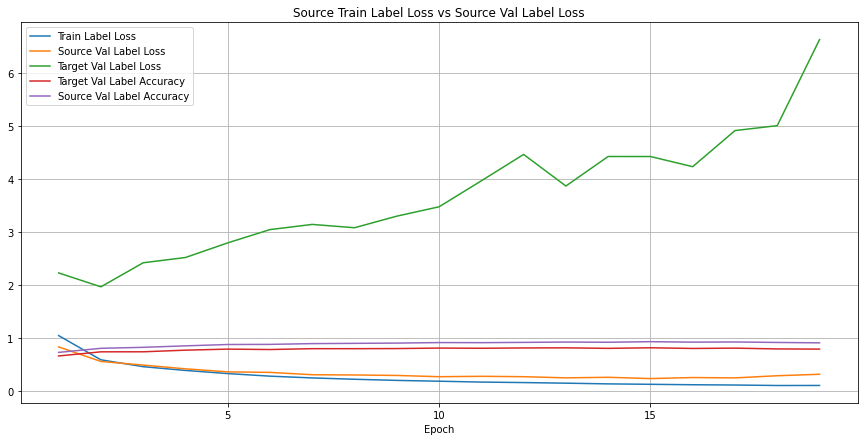

In [16]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

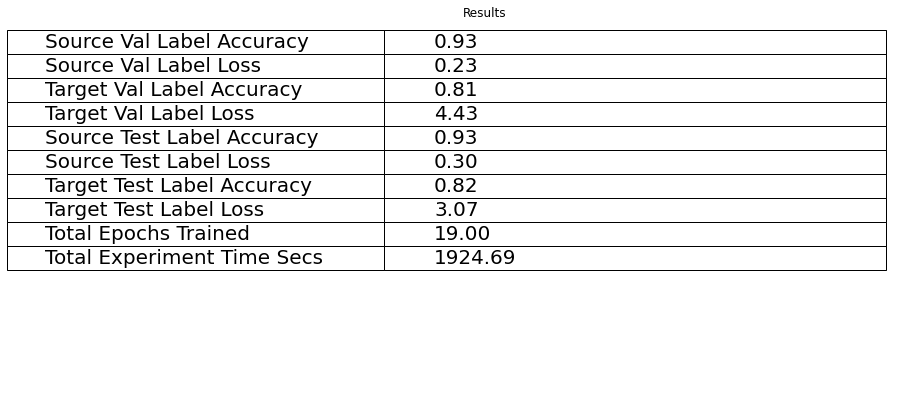

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

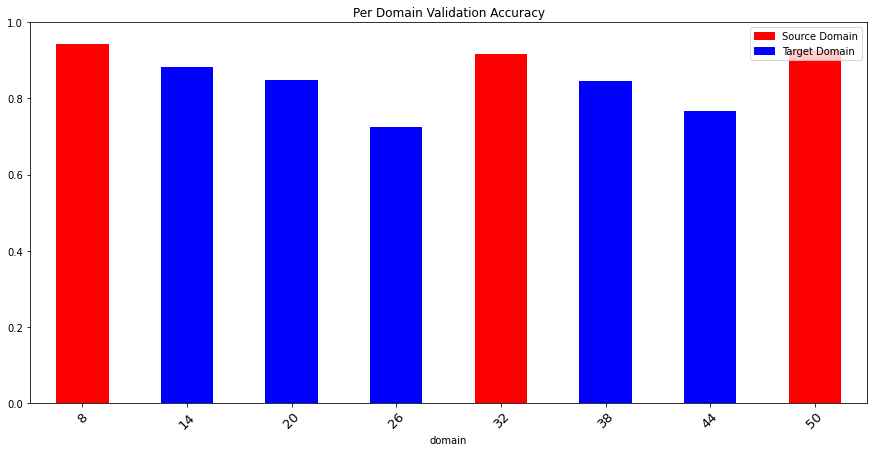

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9296875 Target Test Label Accuracy: 0.8223958333333333
Source Val Label Accuracy: 0.9293402777777777 Target Val Label Accuracy: 0.8140104166666666


In [20]:
json.dumps(experiment)

'{"experiment_name": "tuned_1v2:oracle.run1.framed", "parameters": {"experiment_name": "tuned_1v2:oracle.run1.framed", "device": "cuda", "lr": 0.0001, "labels_source": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "labels_target": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "episode_transforms_source": [], "episode_transforms_target": [], "domains_source": [8, 32, 50], "domains_target": [14, 20, 26, 38, 44], "num_examples_per_domain_per_label_source": -1, "num_examples_per_domain_per_label_target": -1, "n_shot": 3, "n_way": 16, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"clas